<a href="https://colab.research.google.com/github/Pallavi5775/text-gen/blob/main/revised_generator_optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%env CUDA_LAUNCH_BLOCKING=1

env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
!pip install torch torchvision tensorflow keras numpy matplotlib opencv-python


In [1]:
import cv2
import os
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
!cd "/content/drive/My Drive/image_parts" && ls -lh


total 913M
-rw------- 1 root root 913M Dec 29 19:35 images.zip


In [ ]:
!unzip -tq "/content/drive/Shared with me/images.zip"


No errors detected in compressed data of /content/drive/My Drive/image_parts/images.zip.


In [3]:
!unzip "/content/drive/My Drive/image_parts/images.zip" -d "/content/dataset"


Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/images/3_0_2_20161219141852353.jpg  
  inflating: /content/dataset/images/3_0_2_20161219142321097.jpg  
  inflating: /content/dataset/images/3_0_2_20161219142512185.jpg  
  inflating: /content/dataset/images/3_0_2_20161219142551561.jpg  
  inflating: /content/dataset/images/3_0_2_20161219142553649.jpg  
  inflating: /content/dataset/images/3_0_2_20161219151511755.jpg  
  inflating: /content/dataset/images/3_0_2_20161219151938084.jpg  
  inflating: /content/dataset/images/3_0_2_20161219153035532.jpg  
  inflating: /content/dataset/images/3_0_2_20161219154525565.jpg  
  inflating: /content/dataset/images/3_0_2_20161219160003893.jpg  
  inflating: /content/dataset/images/3_0_2_20161219160259510.jpg  
  inflating: /content/dataset/images/3_0_2_20161219160753533.jpg  
  inflating: /content/dataset/images/3_0_2_20161219160801053.jpg  
  inflating: /content/dataset/images/3_0_2_20161219161653119.jpg  
  inflating

In [4]:
import torch
# from torch.utils.data import DataLoader, TensorDataset

# # Define device (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# device = torch.device('cuda')


In [5]:
def preprocess_images_in_batches(image_dir, output_size=(128, 128), batch_size=64, augment=False):
    """
    Preprocess images in batches to reduce memory usage.

    Parameters:
    - image_dir: Directory containing the images.
    - output_size: Desired size for all images (width, height).
    - batch_size: Number of images to process in one batch.
    - augment: Whether to apply data augmentation.

    Yields:
    - Batch of preprocessed images and labels.
    """
    images, labels = [], []
    valid_extensions = ('.jpg', '.jpeg', '.png')

    for file_name in os.listdir(image_dir):
        if not file_name.lower().endswith(valid_extensions):
            continue

        file_path = os.path.join(image_dir, file_name)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, output_size)
            img = img / 127.5 - 1

            try:
                age = int(file_name.split('_')[0])
                age_group = age // 10
                images.append(img)
                labels.append(age_group)

                # Data augmentation (optional)
                if augment:
                    flipped_img = np.fliplr(img)
                    images.append(flipped_img)
                    labels.append(age_group)

                # Yield batch when batch size is reached
                if len(images) >= batch_size:
                    yield np.array(images), np.array(labels)
                    images, labels = [], []  # Reset for the next batch
            except ValueError:
                print(f"Skipping file {file_name}: Unable to extract age")

    # Yield the final batch if any images are left
    if images:
        yield np.array(images), np.array(labels)



In [6]:
import cv2
import os
import numpy as np
from collections import Counter
from sklearn.utils import resample
def balance_dataset_in_batches(images, labels, batch_size=64):
    """
    Balance the dataset in batches.

    Parameters:
    - images: Array of images.
    - labels: Array of labels corresponding to images.
    - batch_size: Number of samples per batch.

    Yields:
    - Balanced batch of images and labels.
    """
    unique_labels = np.unique(labels)

    # Calculate the maximum number of samples per label for the batch
    min_samples_per_batch = batch_size // len(unique_labels)

    # Split into batches
    for start_idx in range(0, len(labels), batch_size):
        end_idx = start_idx + batch_size
        batch_images, batch_labels = images[start_idx:end_idx], labels[start_idx:end_idx]

        # Balance the batch
        balanced_images, balanced_labels = [], []
        label_indices = {label: np.where(batch_labels == label)[0] for label in unique_labels}

        for label in unique_labels:
            indices = label_indices[label]
            sampled_indices = resample(indices, n_samples=min_samples_per_batch, random_state=42)
            balanced_images.extend(batch_images[sampled_indices])
            balanced_labels.extend(batch_labels[sampled_indices])

        yield np.array(balanced_images), np.array(balanced_labels)

In [7]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
image_dir = "/content/dataset/images"
# Directories for saving training and validation data
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/val"
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Counter for naming batches
train_counter, val_counter = 0, 0

# Preprocess, balance, and split batches
for images_batch, labels_batch in preprocess_images_in_batches(image_dir, batch_size=64, augment=True):
    print(f"Processed batch of {len(images_batch)} images.")

    # Balance each batch
    for balanced_images_batch, balanced_labels_batch in balance_dataset_in_batches(images_batch, labels_batch, batch_size=64):
        print(f"Balanced batch of {len(balanced_images_batch)} images.")

        # Split balanced batch into training and validation
        X_train, X_val, y_train, y_val = train_test_split(
            balanced_images_batch, balanced_labels_batch, test_size=0.2, random_state=42
        )

        # Save training data
        train_images_path = os.path.join(train_dir, f"images_batch_{train_counter}.npy")
        train_labels_path = os.path.join(train_dir, f"labels_batch_{train_counter}.npy")
        np.save(train_images_path, X_train)
        np.save(train_labels_path, y_train)
        train_counter += 1

        # Save validation data
        val_images_path = os.path.join(val_dir, f"images_batch_{val_counter}.npy")
        val_labels_path = os.path.join(val_dir, f"labels_batch_{val_counter}.npy")
        np.save(val_images_path, X_val)
        np.save(val_labels_path, y_val)
        val_counter += 1

print(f"Saved {train_counter} training batches and {val_counter} validation batches.")






Processed batch of 64 images.
Balanced batch of 63 images.
Processed batch of 64 images.
Balanced batch of 63 images.
Processed batch of 64 images.
Balanced batch of 64 images.
Processed batch of 64 images.
Balanced batch of 63 images.
Processed batch of 64 images.
Balanced batch of 64 images.
Processed batch of 64 images.
Balanced batch of 63 images.
Processed batch of 64 images.
Balanced batch of 63 images.
Processed batch of 64 images.
Balanced batch of 63 images.
Processed batch of 64 images.
Balanced batch of 63 images.
Processed batch of 64 images.
Balanced batch of 64 images.
Processed batch of 64 images.
Balanced batch of 60 images.
Processed batch of 64 images.
Balanced batch of 63 images.
Processed batch of 64 images.
Balanced batch of 64 images.
Processed batch of 64 images.
Balanced batch of 63 images.
Processed batch of 64 images.
Balanced batch of 63 images.
Processed batch of 64 images.
Balanced batch of 64 images.
Processed batch of 64 images.
Balanced batch of 63 image

In [24]:
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/val"

def load_batches_from_disk(batch_dir):
    """
    Generator to load saved batches of images and labels from disk.

    Parameters:
    - batch_dir: Directory containing the saved batches.

    Yields:
    - images: Loaded images for the batch.
    - labels: Loaded labels for the batch.
    """
    batch_files = sorted(os.listdir(batch_dir))
    images_files = [f for f in batch_files if "images_batch" in f]
    labels_files = [f for f in batch_files if "labels_batch" in f]

    for img_file, lbl_file in zip(images_files, labels_files):
        images = np.load(os.path.join(batch_dir, img_file))
        labels = np.load(os.path.join(batch_dir, lbl_file))
        yield images, labels


In [25]:
import torch.nn as nn

def reinitialize_weights(module):
    """
    Reinitialize weights of a module using appropriate initialization methods.
    """
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.ConvTranspose2d):
        # Use Kaiming Initialization for convolutional layers
        nn.init.kaiming_normal_(module.weight, nonlinearity='leaky_relu')
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.Linear):
        # Use Xavier Initialization for fully connected layers
        nn.init.xavier_normal_(module.weight)
        if module.bias is not None:
            nn.init.constant_(module.bias, 0)
    elif isinstance(module, nn.BatchNorm2d):
        # Initialize BatchNorm layers
        nn.init.constant_(module.weight, 1)
        nn.init.constant_(module.bias, 0)


In [26]:
import torch.nn.functional as F

def preprocess_labels(labels, num_classes, image_size):
    """
    Converts scalar labels to one-hot encoded spatial labels.
    Args:
        labels (torch.Tensor): Scalar labels of shape (batch_size,)
        num_classes (int): Number of classes
        image_size (tuple): (height, width)
    Returns:
        torch.Tensor: One-hot encoded labels with spatial dimensions
    """
    batch_size = labels.size(0)
    # Convert scalar labels to one-hot encoding
    one_hot = F.one_hot(labels.long(), num_classes=num_classes).float()  # Shape: (batch_size, num_classes)
    # Add spatial dimensions
    one_hot = one_hot.unsqueeze(-1).unsqueeze(-1)  # Shape: (batch_size, num_classes, 1, 1)
    # Expand to match image dimensions
    one_hot = one_hot.expand(-1, -1, image_size[0], image_size[1])  # Shape: (batch_size, num_classes, height, width)
    return one_hot


In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, downsample=False, norm_type="SpectralNorm"):
        super(ResidualBlock, self).__init__()
        if norm_type == "BatchNorm":
            norm_layer = nn.BatchNorm2d(out_channels)
        elif norm_type == "GroupNorm":
            norm_layer = nn.GroupNorm(num_groups=min(8, out_channels // 4), num_channels=out_channels)
        elif norm_type == "InstanceNorm":
            norm_layer = nn.InstanceNorm2d(out_channels, affine=True)
        else:  # Default to SpectralNorm
            norm_layer = nn.Identity()

        self.conv1 = nn.utils.spectral_norm(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        )
        self.conv2 = nn.utils.spectral_norm(
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1 if not downsample else 2, padding=1)
        )
        self.skip = nn.utils.spectral_norm(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1 if not downsample else 2)
        )
        self.norm = norm_layer
        self.dropout = nn.Dropout(0.3)  # Add dropout with a probability of 0.3
        self.relu = nn.LeakyReLU(0.2, inplace=True)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.relu(residual)
        residual = self.conv2(residual)
        residual = self.dropout(self.norm(residual))  # Apply dropout
        skip = self.skip(x)
        out = residual + skip
        return self.relu(out)
class Discriminator(nn.Module):
    def __init__(self, image_channels, num_classes):
        super(Discriminator, self).__init__()

        print(image_channels, num_classes)
        input_channels = image_channels + num_classes

        # Initial convolution block
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Reduced residual blocks
        self.residual_blocks = nn.Sequential(
            ResidualBlock(64, 128, downsample=True),  # [128x128 -> 64x64]
            ResidualBlock(128, 256, downsample=True),  # [64x64 -> 32x32]
        )

        # Minibatch discrimination
        self.minibatch_discrimination = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 16 * 16, 128),  # Adjust size after reducing residual blocks
            nn.ReLU(inplace=True),
            nn.Linear(128, 64),
        )

        # Shared feature extractor
        self.shared_out = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Outputs
        self.patch_out = nn.Sequential(
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )

        self.aux_classifier = nn.Sequential(
            nn.Conv2d(64, num_classes, kernel_size=3, stride=1, padding=1),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )

    def forward(self, images, labels):
        print("Inside Discriminator ..............................")

        # Preprocess Labels
        label_channels = self.aux_classifier[0].out_channels
        labels = preprocess_labels(labels, label_channels, images.shape[2:])
        labels = labels.clone()  # Clone to avoid shared memory issues
        labels += torch.normal(0, 0.1, labels.shape).to(labels.device)  # Add Gaussian noise
        labels = torch.clamp(labels, 0, 1)  # Clamp values between 0 and 1

        print("Shape of images:", images.shape)
        print("Shape of labels:", labels.shape)

        # Concatenate images and labels
        x = torch.cat([images, labels], dim=1)
        print("Input Shape to initial_conv:", x.shape)

        # Forward pass
        out = self.initial_conv(x)
        out = self.residual_blocks(out)
        minibatch_features = self.minibatch_discrimination(out)
        out = self.shared_out(out)

        # Outputs
        validity = self.patch_out(out)
        aux_pred = self.aux_classifier(out)

        print("Validity Shape:", validity.shape)
        print("Auxiliary Prediction Shape:", aux_pred.shape)

        return validity, aux_pred



In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint

class ScaledResidualBlock(nn.Module):
    def __init__(self, channels, scale=0.1, norm_type="GroupNorm"):
        super(ScaledResidualBlock, self).__init__()
        self.scale = scale
        if norm_type == "BatchNorm":
            norm_layer = nn.BatchNorm2d(channels)
        elif norm_type == "InstanceNorm":
            norm_layer = nn.InstanceNorm2d(channels, affine=True)
        else:  # Default to GroupNorm
            norm_layer = nn.GroupNorm(num_groups=min(8, channels // 4), num_channels=channels)

        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            norm_layer,
            nn.Dropout(0.3),  # Add dropout with a probability of 0.3
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, stride=1, padding=1),
            norm_layer,
        )

    def forward(self, x):
        residual = self.block(x)
        return x + self.scale * residual



class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Conv2d(channels, 1, kernel_size=1)

    def forward(self, x):
        attention_map = torch.sigmoid(self.attention(x))
        return x * attention_map

class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim, label_dim, height=128, width=128):
        super(Generator, self).__init__()
        self.noise_dim = noise_dim
        self.label_dim = label_dim
        self.height = height
        self.width = width

        # Label embedding
        self.label_embedding = nn.Linear(label_dim, noise_dim)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(noise_dim * 2, 256 * 4 * 4), # Input dimension matches combined noise and label size
            nn.LayerNorm([256 * 4 * 4]),  # Corrected to match the output of nn.Linear
            nn.LeakyReLU(0.2, inplace=True),
        )

        # Add a downsampling layer to reduce channels from 256 to 128
        self.downsample = nn.Conv2d(256, 128, kernel_size=1, stride=1)

        # Residual blocks
        self.res_blocks = nn.Sequential(
            ScaledResidualBlock(128),
            ScaledResidualBlock(128),
        )

        # Attention block
        self.attention = AttentionBlock(128)

        # Deconvolution layers
        self.deconv = nn.Sequential(
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 4x4 -> 8x8
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),

    nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 16x16 -> 32x32
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.2, inplace=True),

    nn.ConvTranspose2d(16, 8, kernel_size=4, stride=2, padding=1),   # 32x32 -> 64x64
    nn.BatchNorm2d(8),
    nn.LeakyReLU(0.2, inplace=True),

    nn.ConvTranspose2d(8, 3, kernel_size=4, stride=2, padding=1),    # 64x64 -> 128x128
    nn.Tanh(),
)

    def forward(self, noise, labels_one_hot):

        print("Inside Generator .............................")
        # Embed labels and concatenate with noise
        print("Shape of labels before processing:", labels_one_hot.shape)
        embedded_labels = self.label_embedding(labels_one_hot.float())


        print("Shape after embedded_labels:", embedded_labels.shape)
        combined = torch.cat([noise, embedded_labels], dim=1)
        print("Shape of combined (noise + embedded labels):", combined.shape)  # [51, 200]
        # Fully connected layers
        out = self.fc(combined)
        print("Shape after self.fc:", out.shape)
        batch_size = out.size(0)
        out = out.view(batch_size, 256, 4, 4)

        print("Shape after reshaping out:", out.shape)


        out = self.downsample(out)  # Reduce channels to 128

        print("Shape after downsampling out:", out.shape)

        # Residual blocks with global skip connection
        residual = out
        out = self.res_blocks(out)
        out += residual

        print("Shape after residual block:", out.shape)

        # Attention block
        out = self.attention(out)

        print("Shape after Attention block:", out.shape)

        # Noise injection
        noise_injection = torch.randn_like(out) * 0.1
        out += noise_injection

        print("Shape after Noise injection:", out.shape)

        print("Shape before deconvolution:", out.shape)

        # Deconvolution layers
        out = self.deconv(out)

        print("Min pixel value:", out.min().item())
        print("Max pixel value:", out.max().item())

        print("Shape after Deconvolution layers:", out.shape)

        return out


In [29]:
class PerceptualLoss(nn.Module):
    def __init__(self, feature_extractor):
        super(PerceptualLoss, self).__init__()
        self.feature_extractor = feature_extractor.eval()  # Freeze VGG
        for param in self.feature_extractor.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        # Match batch sizes
        min_batch_size = min(input.size(0), target.size(0))
        input = input[:min_batch_size]
        target = target[:min_batch_size]

        # Ensure input and target have the same spatial dimensions
        if input.size(2) != target.size(2) or input.size(3) != target.size(3):
            target = F.interpolate(target, size=(input.size(2), input.size(3)), mode='bilinear', align_corners=False)

        # Debug shapes
        print(f"Input shape: {input.shape}, Target shape: {target.shape}")

        # Extract features
        input_features = self.feature_extractor(input)
        target_features = self.feature_extractor(target)

        # Debug feature shapes
        print(f"Input features shape: {input_features.shape}, Target features shape: {target_features.shape}")

        # Compute MSE loss between features
        return F.mse_loss(input_features, target_features)




In [30]:
def age_consistency_loss(predicted_ages, target_ages):
    # Flatten predictions to [batch_size * height * width, num_classes]
    batch_size, num_classes, height, width = predicted_ages.size()
    predicted_ages = predicted_ages.permute(0, 2, 3, 1).reshape(-1, num_classes)

    # Expand target to match [batch_size * height * width]
    target_ages = target_ages.unsqueeze(1).unsqueeze(2).expand(-1, height, width).reshape(-1)

    # Compute cross-entropy loss
    return F.cross_entropy(predicted_ages, target_ages)


In [31]:
def train_discriminator(real_images, labels, device, lambda_gp, all_labels, discriminator, generator, real_labels, accumulation_steps, optimizer_discriminator, mean_real_data, std_real_data,epoch, max_epochs):
    """
    Train the discriminator dynamically with optimized memory usage.
    """



    num_classes = all_labels
    print(f"all_labels------------------------>{all_labels}")
    print(f"labels------------------------>{labels}")
    real_images = real_images.to(device).float() / 127.5 - 1.0

    # Apply Instance Noise to Real Images
    noise_std = 0.1  * (1 - epoch / max_epochs)
    real_images_noisy = real_images + torch.randn_like(real_images) * noise_std
    print(f"Shape of Real Images (with Noise): {real_images_noisy.shape}")

    # Forward Pass for Real Images
    real_validity, real_aux_pred = discriminator(real_images_noisy, labels)
    real_validity = real_validity / 10.0  # Normalize validity scores

    print("Validity Shape:", real_validity.shape)  # Output for patch-level validity
    print("Auxiliary Prediction Shape:", real_aux_pred.shape)  # Output for auxiliary classification

    adversarial_loss = nn.BCEWithLogitsLoss()  # Combines sigmoid and BCE for numerical stability

    # Label Smoothing for Real Labels
    real_label_tensor = torch.full(real_validity.size(), 0.9).to(device)  # Real labels = 0.9 (smoothed)
    adv_loss_real = adversarial_loss(real_validity, real_label_tensor)

    # Classification Loss for Real Images
    classification_loss = nn.CrossEntropyLoss()
    aux_loss_real = classification_loss(real_aux_pred, real_labels)

    # Generate Fake Images
    z = torch.randn(real_images.size(0), 100).to(device) * std_real_data + mean_real_data
    labels_one_hot = F.one_hot(labels.long(), num_classes).to(device)
    fake_images = generator(z, labels_one_hot)

    print(f"Min pixel value: {fake_images.min().item()}, Max pixel value: {fake_images.max().item()}")
    print("Shape of real images:", real_images.shape)
    print("Shape of fake images:", fake_images.shape)

    # Apply Instance Noise to Fake Images
    fake_images_noisy = fake_images + torch.randn_like(fake_images) * noise_std
    print(f"Shape of Fake Images (with Noise): {fake_images_noisy.shape}")

    # Forward Pass for Fake Images
    fake_validity, fake_aux_pred = discriminator(fake_images_noisy.detach(), labels)
    fake_validity = fake_validity / 10.0  # Normalize validity scores

    # Adversarial Loss for Fake Images
    fake_label_tensor = torch.full(fake_validity.size(), 0.1).to(device)  # Fake labels = 0.1 (smoothed)
    adv_loss_fake = adversarial_loss(fake_validity, fake_label_tensor)

    # Classification Loss for Fake Images
    aux_loss_fake = classification_loss(fake_aux_pred, labels)

    # Combine Losses
    d_loss_adv = (adv_loss_real + adv_loss_fake) / 2  # Adversarial loss for real and fake
    d_loss_aux = (aux_loss_real + aux_loss_fake) / 2  # Auxiliary classification loss

    # Total Discriminator Loss
    aux_weight = 0.5  # Adjust weight as needed
    d_loss = d_loss_adv + aux_weight * d_loss_aux

    # Optional: Gradient Penalty (for WGAN-GP)
    if lambda_gp > 0:
        alpha = torch.rand(real_images.size(0), 1, 1, 1).to(device)
        interpolates = (alpha * real_images + (1 - alpha) * fake_images).requires_grad_(True)
        interpolates_labels = labels[:real_images.size(0)]  # Align labels
        interpolates_validity, _ = discriminator(interpolates, interpolates_labels)
        gradients = torch.autograd.grad(
            outputs=interpolates_validity,
            inputs=interpolates,
            grad_outputs=torch.ones(interpolates_validity.size()).to(device),
            create_graph=True,
            retain_graph=True,
            only_inputs=True,
        )[0]
        gradients = gradients.view(gradients.size(0), -1)
        gradient_penalty_weight = lambda_gp if lambda_gp > 0 else 0.1
        gradient_penalty = gradient_penalty_weight * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
        d_loss += gradient_penalty

        print(f"Gradient Norm: {gradients.norm(2, dim=1).mean().item()}")

    # Normalize Loss for Accumulation Steps (if using gradient accumulation)
    d_loss = d_loss / accumulation_steps

    # Backward Pass and Update Discriminator
    d_loss.backward()
    torch.nn.utils.clip_grad_norm_(discriminator.parameters(), max_norm=1.0)

    for name, param in discriminator.named_parameters():
        if param.grad is not None:
            print(f"Gradient Norm for {name}: {param.grad.norm().item()}")
    optimizer_discriminator.step()

    del generator, discriminator, z, labels, labels_one_hot, fake_images

    # Log Losses
    print(f"Adversarial Loss (Real): {adv_loss_real.item():.4f}")
    print(f"Adversarial Loss (Fake): {adv_loss_fake.item():.4f}")
    print(f"Auxiliary Loss (Real): {aux_loss_real.item():.4f}")
    print(f"Auxiliary Loss (Fake): {aux_loss_fake.item():.4f}")
    torch.cuda.empty_cache()

    return d_loss


In [32]:
import torchvision
import matplotlib.pyplot as plt

def train_generator(device, labels, real_images, num_classes, perceptual_loss_fn, discriminator, generator,epoch,batch_idx, generator_optimizer):
    """
    Train the generator dynamically with optimized memory usage.
    """
    # Initial setup and noise generation
    output_dim = real_images.size(1)  # Number of channels in real images
    noise_dim = 100  # Dimension of latent space


    # Generate noise and labels
    noise = torch.randn(real_images.size(0), noise_dim, device=device) * 2

    # labels = torch.randint(0, num_classes, (real_images.size(0),), device=device)
    labels_generator = F.one_hot(labels.long(), num_classes=num_classes).float()

    # Generate fake images
    fake_images = generator(noise, labels_generator)
    # fake_images = torch.clamp(fake_images, min=-1.0, max=1.0)  # Clamp to [-1, 1]

    # # Normalize images from [-1, 1] to [0, 1]
    # normalized_fake_images = (fake_images + 1) / 2

    # # Convert the tensor to a grid of images
    # grid = torchvision.utils.make_grid(normalized_fake_images, nrow=8)

    # # Display the images
    # plt.figure(figsize=(10, 10))
    # plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
    # plt.axis("off")
    # plt.title(f"Generated Images - Epoch {epoch}, Batch {batch_idx}")
    # plt.show()

    print(f"Min pixel value: {fake_images.min()}, Max pixel value: {fake_images.max()}")

    # Adjust batch sizes
    # min_batch_size = min(real_images.size(0), fake_images.size(0))
    # real_images = real_images[:min_batch_size]
    # fake_images = fake_images[:min_batch_size]
    # labels = labels[:min_batch_size]
    validity_fake, age_fake_pred = discriminator(fake_images.detach(), labels)

    print(f"Discriminator output for fake images (validity_fake): {validity_fake.mean().item()}")

    print(f"Shape of age_fake_pred_pooled: {age_fake_pred.shape}")
    print(f"Shape of labels: {labels.shape}")
    # Adversarial loss (WGAN)
    adv_loss = -validity_fake.mean() / 1000.0  # Normalize validity

    print(f"Shape of labels for aux_loss: {labels.shape}")  # Expected: [batch_size]
    print(f"Labels range for aux_loss: {labels.min().item()} to {labels.max().item()}")  # Should be within [0, num_classes-1]

    aux_loss = F.cross_entropy(age_fake_pred, labels)
    print(f"Auxiliary loss: {aux_loss.item()}")

    # # Normalize real images for perceptual loss
    # real_images = real_images.to(device).float() / 127.5 - 1.0


    # print(f"fake_images shape: {fake_images.shape}")
    # print(f"real_images shape: {real_images.shape}")



    # min_batch_size = min(fake_images.size(0), real_images.size(0))
    # fake_images = fake_images[:min_batch_size]
    # real_images = real_images[:min_batch_size]

    # # Perceptual loss for identity preservation
    # perceptual_loss = perceptual_loss_fn(fake_images, real_images)

    # Total generator loss
    perceptual_loss = perceptual_loss_fn(fake_images, real_images) if perceptual_loss_fn is not None else torch.tensor(0.0)
    # Total generator loss
    # g_loss = 0.6 * adv_loss + 0.4 * aux_loss
    g_loss_weight = 1.2  # Increase weight slightly
    g_loss = g_loss_weight * (adv_loss + aux_loss + perceptual_loss)
    # Backpropagation and optimizer step
    generator_optimizer.zero_grad()
    g_loss.backward()
    torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)

    # Log gradient statistics
    for name, param in generator.named_parameters():
      if param.grad is not None and param.grad.norm().item() > 1.0:
          print(f"High Gradient in {name}: {param.grad.norm().item()}")

    for param_group in generator_optimizer.param_groups:
        if 'res_blocks' in param_group['params']:
            param_group['lr'] *= 1.5  # Scale up for residual blocks

    generator_optimizer.step()

    # Clear memory
    del generator, discriminator, noise, labels, labels_generator, fake_images
    torch.cuda.empty_cache()

    return g_loss


In [33]:
def get_num_classes(loader):
    """
    Determine the number of unique classes from a DataLoader.

    Parameters:
    - loader: A DataLoader object containing the dataset.

    Returns:
    - num_classes: The total number of unique classes in the dataset.
    """
    unique_labels = set()

    for _, labels in loader:
        print(f"unique_labels---->{labels.unique().tolist()}")
        unique_labels.update(labels.unique().tolist())
    print(f"unique_labels---->{unique_labels}")
    return len(unique_labels)


In [37]:
    sum_pixels = 0
    sum_squared_pixels = 0
    num_pixels = 0

    for images, _ in train_loader:  # Only need images, ignore labels
        # Flatten the image tensors
        images = images.reshape(images.size(0), -1) # [batch_size, H*W*C]
        sum_pixels += images.sum(dim=1).sum().item()
        sum_squared_pixels += (images ** 2).sum(dim=1).sum().item()
        num_pixels += images.numel()  # Total number of pixels in the batch

    mean_real_data = sum_pixels / num_pixels
    std_real_data = (sum_squared_pixels / num_pixels - mean_real_data ** 2) ** 0.5

    print(f"Mean: {mean_real_data}, Std: {std_real_data}")

Mean: -0.028734638551144852, Std: 0.5955331124823803


In [39]:
import torch
import torch.profiler
import time
from tqdm import tqdm  # Progress bar
import matplotlib.pyplot as plt
from torchvision.models import vgg19
import numpy as np

import os
import psutil
import matplotlib.pyplot as plt
import torchvision.utils as vutils
import gc

def train_gan(mean_real_data, std_real_data, train_loader, val_loader, epochs, device=None, lambda_gp=10, generator_steps=2, patience=5, accumulation_steps=4):
    if device is None:
        device = torch.device("cuda")
    print(f"Using device: {device}")

    # Initialize Discriminator and Generator models
    num_classes = get_num_classes(train_loader)
    # num_classes = 12
    print(f"Number of classes: {num_classes}")

    # Initialize the generator
    noise_dim = 100  # Dimension of latent space (e.g., noise vector)
    output_dim = 3  # Number of output image channels (e.g., RGB)



    print("Testing Generator Initialization...")
    try:
        generator = Generator(noise_dim=noise_dim, output_dim=output_dim, label_dim=num_classes).to(device)
        generator.apply(reinitialize_weights)
        print("Generator Initialized Successfully.")
    except Exception as e:
        print(f"Error Initializing Generator: {e}")


    # label_dim = len(unique_labels)  # Dynamically determined from dataset
    # generator = Generator(noise_dim=100, output_dim=3, label_dim=label_dim).to(device)
    # discriminator = Discriminator(image_channels=3, label_channels=label_dim).to(device)

    print(f"Generator Initiallized")

    # Initialize the discriminator
    image_channels = output_dim  # Input image channels (e.g., RGB)
    label_channels = num_classes  # Number of label channels (for concatenation or conditioning)
    print("Testing Discriminator Initialization...")
    try:
        image_channels = 3      # Number of channels in the input image (e.g., RGB images have 3 channels)
       # Number of classes for auxiliary classification

        # Initialize the model
        discriminator = Discriminator(image_channels, num_classes).to(device)
        discriminator.apply(reinitialize_weights)
        print("Discriminator Initialized Successfully.")
    except Exception as e:
        print(f"Error Initializing Discriminator: {e}")

    print(f"Discriminator Initiallized")

    discriminator_optimizer = torch.optim.AdamW(
      discriminator.parameters(), lr=1e-4, betas=(0.5, 0.999), weight_decay=1e-4  # Add weight decay
  )
    generator_optimizer = torch.optim.AdamW(
      generator.parameters(), lr=2e-4, betas=(0.5, 0.999), weight_decay=1e-4
  )

    print(f"Optimizers Initiallized")

    # Preload the pre-trained VGG for perceptual loss
    pretrained_vgg = vgg19(pretrained=True).features[:16].to(device)
    perceptual_loss_fn = PerceptualLoss(pretrained_vgg).to(device)

    d_losses, g_losses, val_d_losses, val_g_losses = [], [], [], []
    best_d_loss, best_g_loss = float("inf"), float("inf")
    epochs_without_improvement = 0
    threshold = 0.01

    print(f"Starting epoch training")







    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        d_loss_epoch, g_loss_epoch = 0.0, 0.0


            # Optionally freeze discriminator every 5 epochs
        if (epoch + 1) % 5 == 0:
            print("Freezing Discriminator for this epoch...")
            for param in discriminator.parameters():
                param.requires_grad = False
        else:
            for param in discriminator.parameters():
                param.requires_grad = True

        # Training Phase
        for step, (real_images, labels) in enumerate(tqdm(train_loader, desc=f"Training Epoch {epoch + 1}")):
            if step >= 2:  # Limit to the first two batches for testing purposes
                break
            d_loss = torch.tensor(0.0, device=device)
            real_images = real_images.to(device, dtype=torch.float32)
            labels = labels.to(device, dtype=torch.long)
            print(".......................................................")
            print("Training Discrimnator")
            print(".......................................................")
            if step % 2 == 0 and discriminator.parameters().__next__().requires_grad:
             # 1. Set models to training mode

                  discriminator.train()
                  # Train Discrimnator
                  d_loss = train_discriminator(real_images,
                                              labels,
                                              device,
                                              lambda_gp,
                                              num_classes,
                                              discriminator,
                                              generator,
                                              labels,
                                              accumulation_steps,
                                              discriminator_optimizer,
                                              mean_real_data,
                                              std_real_data,
                                              epoch,
                                              epochs
                                              )
                  d_loss = d_loss / accumulation_steps  # Normalize loss for accumulation

                  if (step + 1) % accumulation_steps == 0:
                      discriminator_optimizer.step()
                      discriminator_optimizer.zero_grad()

                  d_loss_epoch += d_loss * accumulation_steps  # Accumulate full loss



            print(".......................................................")
            print("Training Generator...............")

            print(".......................................................")
            # Perform multiple generator updates
            generator.train()
            for g_step in range(generator_steps):  # Perform 'generator_steps' updates for each discriminator step
                g_loss = train_generator(
                    device,labels, real_images, num_classes, perceptual_loss_fn, discriminator, generator, epoch, step, generator_optimizer
                )
                g_loss = g_loss / accumulation_steps  # Normalize loss for accumulation

                if (step + 1) % accumulation_steps == 0:
                    generator_optimizer.step()
                    generator_optimizer.zero_grad()

                g_loss_epoch += g_loss * accumulation_steps  # Accumulate full loss for all generator steps
            print(f"Epoch {epoch}, G Loss: {g_loss.item()}, D Loss: {d_loss.item()}")
            # Visualize generated images after generator updates
            if step % 10 == 0:  # Visualize every 10 steps
                generator.eval()
                discriminator.eval()
                with torch.no_grad():
                    noise = torch.randn(real_images.size(0), noise_dim, device=device)
                    labels_generator = torch.randint(0, num_classes, (real_images.size(0),), device=device)
                    labels_one_hot = F.one_hot(labels_generator, num_classes=num_classes).float()
                    fake_images = generator(noise, labels_one_hot)

                    fake_images = torch.clamp(fake_images, min=-1.0, max=1.0)  # Clamp to [-1, 1]
                    fake_images = (fake_images + 1) / 2  # Normalize to [0, 1]
                    fake_images = (fake_images * 255).to(torch.uint8)  # Convert to [0, 255]

                    # Visualize the first generated image
                    plt.imshow(fake_images[0].cpu().detach().numpy().transpose(1, 2, 0))
                    plt.show()

                    generator.train()  # Switch back to training mode
            # Free memory explicitly
            del real_images, labels, g_loss, d_loss
            gc.collect()

        # Record average losses
        d_losses.append(d_loss_epoch / len(train_loader))
        g_losses.append(g_loss_epoch / (len(train_loader) * generator_steps))  # Normalize by total generator steps
        print(f"Training: Epoch {epoch + 1} - D Loss: {d_losses[-1]:.4f}, G Loss: {g_losses[-1]:.4f}")

    return d_losses, g_losses, val_d_losses, val_g_losses











In [ ]:
import numpy as np

# Check a few saved batches
for idx in range(3):
    train_images = np.load(f"/content/dataset/train/images_batch_{idx}.npy")
    train_labels = np.load(f"/content/dataset/train/labels_batch_{idx}.npy")
    print(f"Train Batch {idx} - Images Shape: {train_images.shape}, Labels Shape: {train_labels.shape}")

    val_images = np.load(f"/content/dataset/val/images_batch_{idx}.npy")
    val_labels = np.load(f"/content/dataset/val/labels_batch_{idx}.npy")
    print(f"Val Batch {idx} - Images Shape: {val_images.shape}, Labels Shape: {val_labels.shape}")

Train Batch 0 - Images Shape: (51, 128, 128, 3), Labels Shape: (51,)
Val Batch 0 - Images Shape: (13, 128, 128, 3), Labels Shape: (13,)
Train Batch 1 - Images Shape: (51, 128, 128, 3), Labels Shape: (51,)
Val Batch 1 - Images Shape: (13, 128, 128, 3), Labels Shape: (13,)
Train Batch 2 - Images Shape: (50, 128, 128, 3), Labels Shape: (50,)
Val Batch 2 - Images Shape: (13, 128, 128, 3), Labels Shape: (13,)


In [35]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, data_dir):
        """
        Dataset for loading image and label batches stored as .npy files in the directory.

        Args:
            data_dir (str): Path to the directory containing the image and label .npy files.
        """
        self.image_paths = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if 'images_batch' in f])
        self.label_paths = sorted([os.path.join(data_dir, f) for f in os.listdir(data_dir) if 'labels_batch' in f])
        assert len(self.image_paths) == len(self.label_paths), "Mismatch in number of image and label files."

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            # Load images and labels
            images = np.load(self.image_paths[idx])  # Shape: [batch_size, H, W, C]
            labels = np.load(self.label_paths[idx])  # Shape: [batch_size]

            # Convert to tensors
            images = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)  # Convert to [N, C, H, W]
            labels = torch.tensor(labels, dtype=torch.long)
            return images, labels
        except Exception as e:
            print(f"Error loading file {self.image_paths[idx]} or {self.label_paths[idx]}: {e}")
            return None, None

def custom_collate_fn(batch):
    """
    Custom collate function to handle None values in the dataset.
    """
    batch = [(images, labels) for images, labels in batch if images is not None and labels is not None]
    if len(batch) == 0:
        return torch.empty(0), torch.empty(0)

    images, labels = zip(*batch)
    images = torch.cat(images, dim=0)  # Concatenate along batch dimension
    labels = torch.cat(labels, dim=0)  # Concatenate labels
    return images, labels





In [36]:
from torch.utils.data import DataLoader
# Directories
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/val"

train_dataset = ImageDataset(train_dir)
val_dataset = ImageDataset(val_dir)

train_loader = DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=4, collate_fn=custom_collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=1, shuffle=False, num_workers=4, collate_fn=custom_collate_fn
)

print(f"Training batches: {len(train_dataset)}")
print(f"Validation batches: {len(val_dataset)}")


Training batches: 377
Validation batches: 377


Using device: cpu
Number of classes: 12
Testing Generator Initialization...
Generator Initialized Successfully.
Generator Initiallized
Testing Discriminator Initialization...
3 12
Discriminator Initialized Successfully.
Discriminator Initiallized
Optimizers Initiallized
Starting epoch training
Epoch 1/60


Training Epoch 1:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 5, 7, 0, 2, 7, 1, 0, 5, 0, 6, 2, 7, 6, 7, 3, 3, 9, 9, 1, 3, 3, 3, 6,
        1, 5, 9, 6, 5, 3, 6, 7, 0, 2, 0, 9, 5, 5, 2, 7, 1, 2, 2, 9, 2, 0, 6, 1,
        3, 7, 5])
Shape of Real Images (with Noise): torch.Size([51, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([51, 3, 128, 128])
Shape of labels: torch.Size([51, 12, 128, 128])
Input Shape to initial_conv: torch.Size([51, 15, 128, 128])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (nois

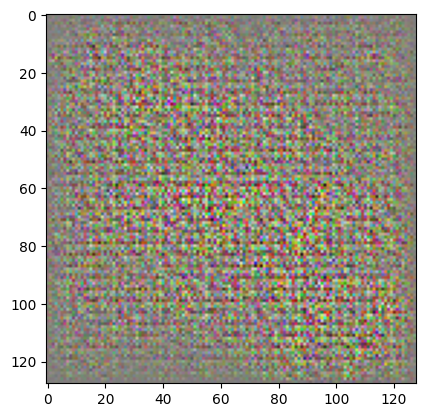

Training Epoch 1:   0%|          | 1/377 [01:38<10:14:55, 98.13s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (noise + embedded labels): torch.Size([51, 200])
Shape after self.fc: torch.Size([51, 4096])
Shape after reshaping out: torch.Size([51, 256, 4, 4])
Shape after downsampling out: torch.Size([51, 128, 4, 4])
Shape after residual block: torch.Size([51, 128, 4, 4])
Shape after Attention block: torch.Size([51, 128, 4, 4])
Shape after Noise injection: torch.Size([51, 128, 4, 4])
Shape before deconvolution: torch.Size([51, 128, 4, 4])
Min pixel value: -0.9999962449073792
Max pixel value: 0.9999988079071045
Shape after Deconvolution layers: torch.Siz

Training Epoch 1:   1%|          | 2/377 [02:33<8:00:33, 76.89s/it]


Epoch 0, G Loss: 4.957386016845703, D Loss: 0.0
Training: Epoch 1 - D Loss: 0.0078, G Loss: 0.1071
Epoch 2/60


Training Epoch 2:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 4, 6, 0, 2, 6, 1, 0, 4, 0, 5, 2, 6, 5, 6, 3, 3, 7, 7, 1, 3, 3, 3, 5,
        1, 4, 7, 5, 4, 3, 5, 6, 0, 2, 0, 7, 4, 4, 2, 6, 1, 2, 2, 7, 2, 0, 5, 1,
        3, 6, 4])
Shape of Real Images (with Noise): torch.Size([51, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([51, 3, 128, 128])
Shape of labels: torch.Size([51, 12, 128, 128])
Input Shape to initial_conv: torch.Size([51, 15, 128, 128])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (nois

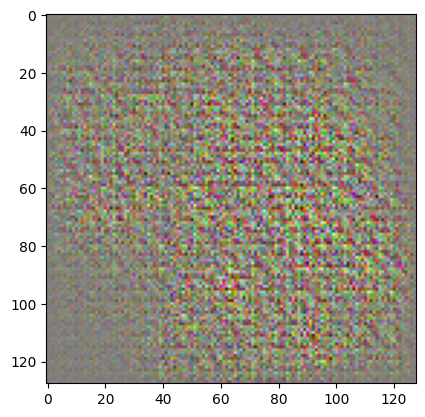

Training Epoch 2:   0%|          | 1/377 [01:36<10:06:19, 96.75s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (noise + embedded labels): torch.Size([51, 200])
Shape after self.fc: torch.Size([51, 4096])
Shape after reshaping out: torch.Size([51, 256, 4, 4])
Shape after downsampling out: torch.Size([51, 128, 4, 4])
Shape after residual block: torch.Size([51, 128, 4, 4])
Shape after Attention block: torch.Size([51, 128, 4, 4])
Shape after Noise injection: torch.Size([51, 128, 4, 4])
Shape before deconvolution: torch.Size([51, 128, 4, 4])
Min pixel value: -0.999998152256012
Max pixel value: 0.999999463558197
Shape after Deconvolution layers: torch.Size(

Training Epoch 2:   1%|          | 2/377 [02:34<7:41:43, 73.88s/it] 

Epoch 1, G Loss: 4.894735336303711, D Loss: 0.0


Training Epoch 2:   1%|          | 2/377 [02:34<8:03:56, 77.43s/it]


Training: Epoch 2 - D Loss: 0.0078, G Loss: 0.1067
Epoch 3/60


Training Epoch 3:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 4, 8, 0, 2, 6, 1, 0, 4, 0, 6, 2, 8, 5, 8, 4, 4, 9, 9, 2, 3, 3, 3, 6,
        1, 4, 9, 6, 5, 4, 6, 0, 3, 0, 8, 5, 5, 3, 8, 1, 3, 2, 9, 2, 1, 6, 2, 4,
        8, 5])
Shape of Real Images (with Noise): torch.Size([50, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([50, 3, 128, 128])
Shape of labels: torch.Size([50, 12, 128, 128])
Input Shape to initial_conv: torch.Size([50, 15, 128, 128])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise +

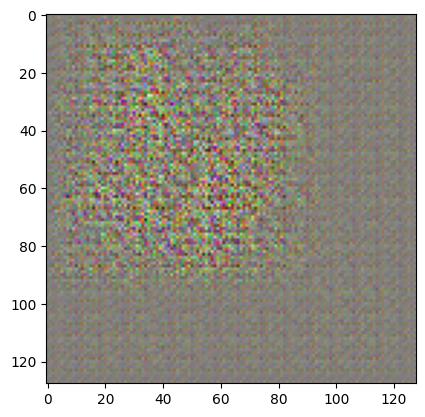

Training Epoch 3:   0%|          | 1/377 [01:33<9:47:57, 93.82s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (noise + embedded labels): torch.Size([51, 200])
Shape after self.fc: torch.Size([51, 4096])
Shape after reshaping out: torch.Size([51, 256, 4, 4])
Shape after downsampling out: torch.Size([51, 128, 4, 4])
Shape after residual block: torch.Size([51, 128, 4, 4])
Shape after Attention block: torch.Size([51, 128, 4, 4])
Shape after Noise injection: torch.Size([51, 128, 4, 4])
Shape before deconvolution: torch.Size([51, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([51, 3, 128, 128])
Min pixel

Training Epoch 3:   1%|          | 2/377 [02:30<7:31:07, 72.18s/it]

Epoch 2, G Loss: 4.5105366706848145, D Loss: 0.0


Training Epoch 3:   1%|          | 2/377 [02:31<7:52:14, 75.56s/it]


Training: Epoch 3 - D Loss: 0.0078, G Loss: 0.0974
Epoch 4/60


Training Epoch 4:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 3, 6, 0, 1, 6, 0, 0, 3, 0, 6, 2, 6, 5, 8, 3, 3, 8, 8, 1, 3, 2, 2, 6,
        1, 3, 8, 5, 5, 3, 6, 0, 2, 0, 6, 5, 3, 2, 6, 1, 2, 2, 8, 2, 0, 5, 1, 3,
        6, 5])
Shape of Real Images (with Noise): torch.Size([50, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([50, 3, 128, 128])
Shape of labels: torch.Size([50, 12, 128, 128])
Input Shape to initial_conv: torch.Size([50, 15, 128, 128])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise +

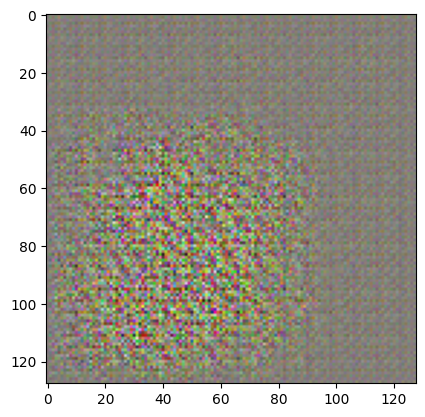

Training Epoch 4:   0%|          | 1/377 [01:38<10:18:58, 98.77s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise + embedded labels): torch.Size([50, 200])
Shape after self.fc: torch.Size([50, 4096])
Shape after reshaping out: torch.Size([50, 256, 4, 4])
Shape after downsampling out: torch.Size([50, 128, 4, 4])
Shape after residual block: torch.Size([50, 128, 4, 4])
Shape after Attention block: torch.Size([50, 128, 4, 4])
Shape after Noise injection: torch.Size([50, 128, 4, 4])
Shape before deconvolution: torch.Size([50, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([50, 3, 128, 128])
Min pixel

Training Epoch 4:   1%|          | 2/377 [02:33<7:35:57, 72.95s/it] 

Epoch 3, G Loss: 4.218485355377197, D Loss: 0.0


Training Epoch 4:   1%|          | 2/377 [02:33<8:01:04, 76.97s/it]


Training: Epoch 4 - D Loss: 0.0078, G Loss: 0.0905
Epoch 5/60
Freezing Discriminator for this epoch...


Training Epoch 5:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (noise + embedded labels): torch.Size([51, 200])
Shape after self.fc: torch.Size([51, 4096])
Shape after reshaping out: torch.Size([51, 256, 4, 4])
Shape after downsampling out: torch.Size([51, 128, 4, 4])
Shape after residual block: torch.Size([51, 128, 4, 4])
Shape after Attention block: torch.Size([51, 128, 4, 4])
Shape after Noise injection: torch.Size([51, 128, 4, 4])
Shape before deconvolution: torch.Size([51, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([51, 3, 128, 128])
Min pixel

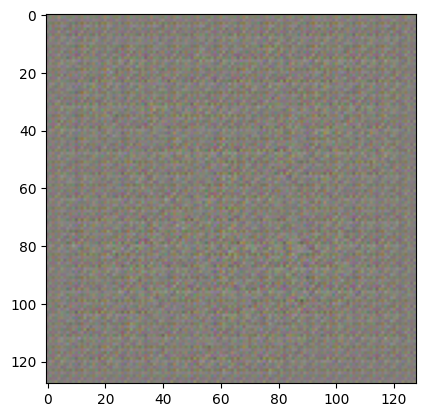

Training Epoch 5:   0%|          | 1/377 [00:48<5:02:58, 48.35s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (noise + embedded labels): torch.Size([51, 200])
Shape after self.fc: torch.Size([51, 4096])
Shape after reshaping out: torch.Size([51, 256, 4, 4])
Shape after downsampling out: torch.Size([51, 128, 4, 4])
Shape after residual block: torch.Size([51, 128, 4, 4])
Shape after Attention block: torch.Size([51, 128, 4, 4])
Shape after Noise injection: torch.Size([51, 128, 4, 4])
Shape before deconvolution: torch.Size([51, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([51, 3, 128, 128])
Min pixel

Training Epoch 5:   1%|          | 2/377 [01:33<4:51:32, 46.65s/it]

Epoch 4, G Loss: 4.170954704284668, D Loss: 0.0


Training Epoch 5:   1%|          | 2/377 [01:34<4:54:00, 47.04s/it]


Training: Epoch 5 - D Loss: 0.0000, G Loss: 0.0898
Epoch 6/60


Training Epoch 6:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 5, 7, 0, 2, 7, 1, 0, 5, 0, 6, 2, 7, 6, 7, 3, 3, 8, 8, 1, 3, 3, 3, 6,
        1, 5, 8, 6, 5, 3, 6, 7, 0, 2, 0, 8, 5, 5, 2, 7, 1, 2, 2, 8, 2, 0, 6, 1,
        3, 7, 5])
Shape of Real Images (with Noise): torch.Size([51, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([51, 3, 128, 128])
Shape of labels: torch.Size([51, 12, 128, 128])
Input Shape to initial_conv: torch.Size([51, 15, 128, 128])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (nois

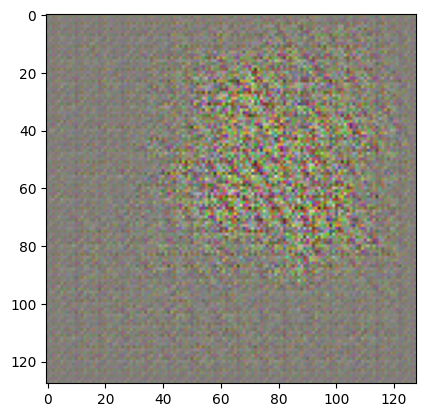

Training Epoch 6:   0%|          | 1/377 [01:39<10:23:51, 99.55s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise + embedded labels): torch.Size([50, 200])
Shape after self.fc: torch.Size([50, 4096])
Shape after reshaping out: torch.Size([50, 256, 4, 4])
Shape after downsampling out: torch.Size([50, 128, 4, 4])
Shape after residual block: torch.Size([50, 128, 4, 4])
Shape after Attention block: torch.Size([50, 128, 4, 4])
Shape after Noise injection: torch.Size([50, 128, 4, 4])
Shape before deconvolution: torch.Size([50, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([50, 3, 128, 128])
Min pixel

Training Epoch 6:   1%|          | 2/377 [02:33<7:34:29, 72.72s/it] 

Epoch 5, G Loss: 4.274176120758057, D Loss: 0.0


Training Epoch 6:   1%|          | 2/377 [02:33<8:00:28, 76.88s/it]


Training: Epoch 6 - D Loss: 0.0077, G Loss: 0.0876
Epoch 7/60


Training Epoch 7:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 4, 7, 0, 2, 6, 1, 0, 4, 0, 6, 2, 7, 5, 7, 4, 4, 8, 8, 2, 3, 3, 3, 6,
        1, 4, 8, 6, 5, 4, 6, 0, 3, 0, 7, 5, 5, 3, 7, 1, 3, 2, 8, 2, 1, 6, 2, 4,
        7, 5])
Shape of Real Images (with Noise): torch.Size([50, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([50, 3, 128, 128])
Shape of labels: torch.Size([50, 12, 128, 128])
Input Shape to initial_conv: torch.Size([50, 15, 128, 128])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise +

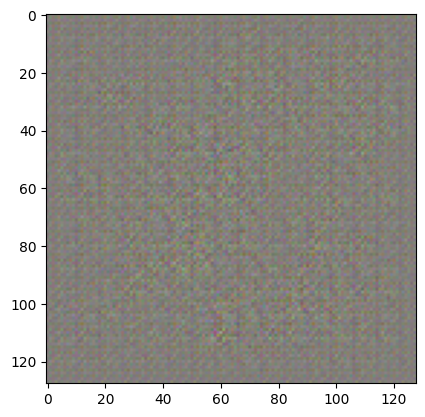

Training Epoch 7:   0%|          | 1/377 [01:33<9:48:37, 93.93s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise + embedded labels): torch.Size([50, 200])
Shape after self.fc: torch.Size([50, 4096])
Shape after reshaping out: torch.Size([50, 256, 4, 4])
Shape after downsampling out: torch.Size([50, 128, 4, 4])
Shape after residual block: torch.Size([50, 128, 4, 4])
Shape after Attention block: torch.Size([50, 128, 4, 4])
Shape after Noise injection: torch.Size([50, 128, 4, 4])
Shape before deconvolution: torch.Size([50, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([50, 3, 128, 128])
Min pixel

Training Epoch 7:   1%|          | 2/377 [02:28<7:21:28, 70.64s/it]

Epoch 6, G Loss: 4.0734782218933105, D Loss: 0.0


Training Epoch 7:   1%|          | 2/377 [02:28<7:44:21, 74.30s/it]


Training: Epoch 7 - D Loss: 0.0077, G Loss: 0.0839
Epoch 8/60


Training Epoch 8:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 4, 6, 0, 2, 6, 1, 0, 4, 0, 5, 2, 6, 5, 6, 3, 3, 7, 7, 1, 3, 3, 3, 5,
        1, 4, 7, 5, 4, 3, 5, 6, 0, 2, 0, 7, 4, 4, 2, 6, 1, 2, 2, 7, 2, 0, 5, 1,
        3, 6, 4])
Shape of Real Images (with Noise): torch.Size([51, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([51, 3, 128, 128])
Shape of labels: torch.Size([51, 12, 128, 128])
Input Shape to initial_conv: torch.Size([51, 15, 128, 128])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (nois

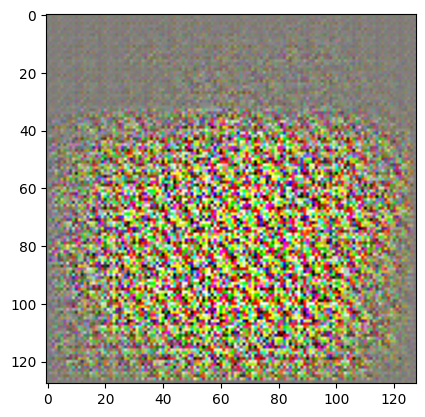

Training Epoch 8:   0%|          | 1/377 [01:38<10:19:23, 98.84s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise + embedded labels): torch.Size([50, 200])
Shape after self.fc: torch.Size([50, 4096])
Shape after reshaping out: torch.Size([50, 256, 4, 4])
Shape after downsampling out: torch.Size([50, 128, 4, 4])
Shape after residual block: torch.Size([50, 128, 4, 4])
Shape after Attention block: torch.Size([50, 128, 4, 4])
Shape after Noise injection: torch.Size([50, 128, 4, 4])
Shape before deconvolution: torch.Size([50, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([50, 3, 128, 128])
Min pixel

Training Epoch 8:   1%|          | 2/377 [02:32<7:31:54, 72.30s/it] 

Epoch 7, G Loss: 3.9456748962402344, D Loss: 0.0


Training Epoch 8:   1%|          | 2/377 [02:32<7:57:51, 76.46s/it]


Training: Epoch 8 - D Loss: 0.0077, G Loss: 0.0849
Epoch 9/60


Training Epoch 9:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 4, 6, 0, 2, 6, 1, 0, 4, 0, 5, 2, 6, 5, 6, 3, 3, 7, 7, 1, 3, 3, 3, 5,
        1, 4, 7, 5, 4, 3, 5, 6, 0, 2, 0, 7, 4, 4, 2, 6, 1, 2, 2, 7, 2, 0, 5, 1,
        3, 6, 4])
Shape of Real Images (with Noise): torch.Size([51, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([51, 3, 128, 128])
Shape of labels: torch.Size([51, 12, 128, 128])
Input Shape to initial_conv: torch.Size([51, 15, 128, 128])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (nois

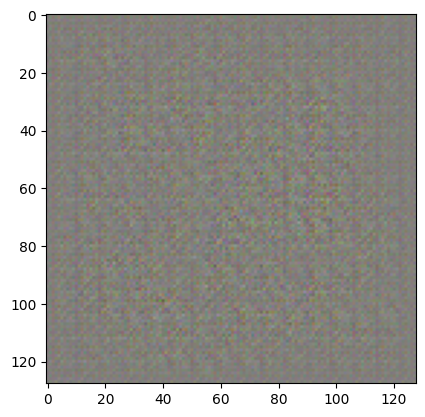

Training Epoch 9:   0%|          | 1/377 [01:35<9:57:14, 95.30s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (noise + embedded labels): torch.Size([51, 200])
Shape after self.fc: torch.Size([51, 4096])
Shape after reshaping out: torch.Size([51, 256, 4, 4])
Shape after downsampling out: torch.Size([51, 128, 4, 4])
Shape after residual block: torch.Size([51, 128, 4, 4])
Shape after Attention block: torch.Size([51, 128, 4, 4])
Shape after Noise injection: torch.Size([51, 128, 4, 4])
Shape before deconvolution: torch.Size([51, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([51, 3, 128, 128])
Min pixel

Training Epoch 9:   1%|          | 2/377 [02:31<7:53:26, 75.75s/it]


Training: Epoch 9 - D Loss: 0.0076, G Loss: 0.0841
Epoch 10/60
Freezing Discriminator for this epoch...


Training Epoch 10:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise + embedded labels): torch.Size([50, 200])
Shape after self.fc: torch.Size([50, 4096])
Shape after reshaping out: torch.Size([50, 256, 4, 4])
Shape after downsampling out: torch.Size([50, 128, 4, 4])
Shape after residual block: torch.Size([50, 128, 4, 4])
Shape after Attention block: torch.Size([50, 128, 4, 4])
Shape after Noise injection: torch.Size([50, 128, 4, 4])
Shape before deconvolution: torch.Size([50, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([50, 3, 128, 128])
Min pixel

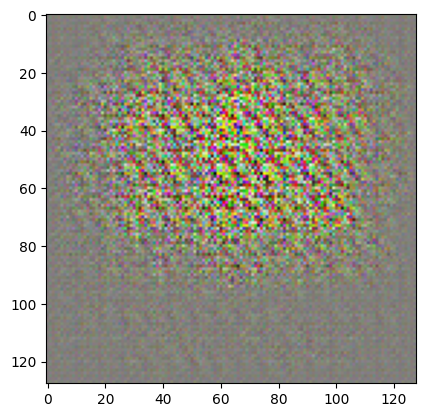

Training Epoch 10:   0%|          | 1/377 [00:43<4:33:28, 43.64s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise + embedded labels): torch.Size([50, 200])
Shape after self.fc: torch.Size([50, 4096])
Shape after reshaping out: torch.Size([50, 256, 4, 4])
Shape after downsampling out: torch.Size([50, 128, 4, 4])
Shape after residual block: torch.Size([50, 128, 4, 4])
Shape after Attention block: torch.Size([50, 128, 4, 4])
Shape after Noise injection: torch.Size([50, 128, 4, 4])
Shape before deconvolution: torch.Size([50, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([50, 3, 128, 128])
Min pixel

Training Epoch 10:   1%|          | 2/377 [01:26<4:29:28, 43.12s/it]

Epoch 9, G Loss: 3.748981237411499, D Loss: 0.0


Training Epoch 10:   1%|          | 2/377 [01:26<4:31:34, 43.45s/it]


Training: Epoch 10 - D Loss: 0.0000, G Loss: 0.0814
Epoch 11/60


Training Epoch 11:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 4, 6, 0, 2, 6, 1, 0, 4, 0, 5, 2, 6, 5, 6, 3, 3, 7, 7, 1, 3, 3, 3, 5,
        1, 4, 7, 5, 4, 3, 5, 6, 0, 2, 0, 7, 4, 4, 2, 6, 1, 2, 2, 7, 2, 0, 5, 1,
        3, 6, 4])
Shape of Real Images (with Noise): torch.Size([51, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([51, 3, 128, 128])
Shape of labels: torch.Size([51, 12, 128, 128])
Input Shape to initial_conv: torch.Size([51, 15, 128, 128])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (nois

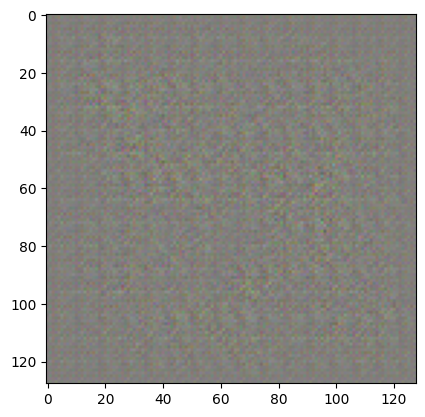

Training Epoch 11:   0%|          | 1/377 [01:34<9:54:43, 94.90s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (noise + embedded labels): torch.Size([51, 200])
Shape after self.fc: torch.Size([51, 4096])
Shape after reshaping out: torch.Size([51, 256, 4, 4])
Shape after downsampling out: torch.Size([51, 128, 4, 4])
Shape after residual block: torch.Size([51, 128, 4, 4])
Shape after Attention block: torch.Size([51, 128, 4, 4])
Shape after Noise injection: torch.Size([51, 128, 4, 4])
Shape before deconvolution: torch.Size([51, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([51, 3, 128, 128])
Min pixel

Training Epoch 11:   1%|          | 2/377 [02:29<7:24:46, 71.16s/it]

Epoch 10, G Loss: 3.611480474472046, D Loss: 0.0


Training Epoch 11:   1%|          | 2/377 [02:29<7:48:25, 74.95s/it]


Training: Epoch 11 - D Loss: 0.0076, G Loss: 0.0779
Epoch 12/60


Training Epoch 12:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 3, 5, 0, 1, 5, 0, 0, 3, 0, 5, 2, 5, 4, 8, 3, 3, 8, 8, 1, 3, 2, 2, 5,
        1, 3, 8, 4, 4, 3, 5, 0, 2, 0, 5, 4, 3, 2, 5, 1, 2, 2, 8, 2, 0, 4, 1, 3,
        5, 4])
Shape of Real Images (with Noise): torch.Size([50, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([50, 3, 128, 128])
Shape of labels: torch.Size([50, 12, 128, 128])
Input Shape to initial_conv: torch.Size([50, 15, 128, 128])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise +

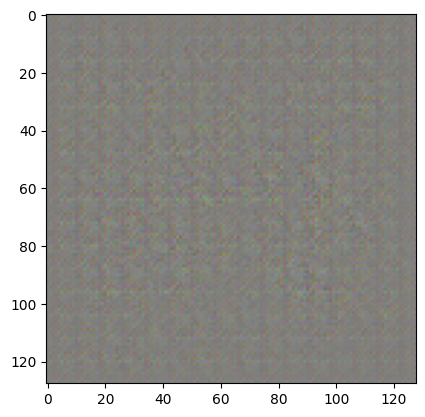

Training Epoch 12:   0%|          | 1/377 [01:32<9:37:23, 92.14s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (noise + embedded labels): torch.Size([51, 200])
Shape after self.fc: torch.Size([51, 4096])
Shape after reshaping out: torch.Size([51, 256, 4, 4])
Shape after downsampling out: torch.Size([51, 128, 4, 4])
Shape after residual block: torch.Size([51, 128, 4, 4])
Shape after Attention block: torch.Size([51, 128, 4, 4])
Shape after Noise injection: torch.Size([51, 128, 4, 4])
Shape before deconvolution: torch.Size([51, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([51, 3, 128, 128])
Min pixel

Training Epoch 12:   1%|          | 2/377 [02:30<7:49:18, 75.09s/it]


Training: Epoch 12 - D Loss: 0.0075, G Loss: 0.0836
Epoch 13/60


Training Epoch 13:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 5, 8, 0, 2, 7, 1, 0, 5, 0, 7, 2, 8, 6, 8, 5, 5, 9, 9, 2, 3, 3, 3, 7,
        1, 5, 9, 7, 6, 5, 7, 0, 3, 0, 8, 6, 6, 3, 8, 1, 3, 2, 9, 2, 1, 7, 2, 5,
        8, 6])
Shape of Real Images (with Noise): torch.Size([50, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([50, 3, 128, 128])
Shape of labels: torch.Size([50, 12, 128, 128])
Input Shape to initial_conv: torch.Size([50, 15, 128, 128])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise +

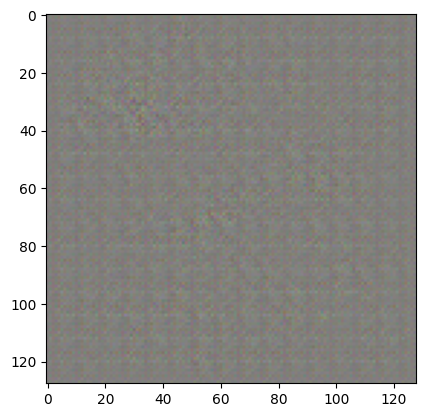

Training Epoch 13:   0%|          | 1/377 [01:32<9:37:32, 92.16s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (noise + embedded labels): torch.Size([51, 200])
Shape after self.fc: torch.Size([51, 4096])
Shape after reshaping out: torch.Size([51, 256, 4, 4])
Shape after downsampling out: torch.Size([51, 128, 4, 4])
Shape after residual block: torch.Size([51, 128, 4, 4])
Shape after Attention block: torch.Size([51, 128, 4, 4])
Shape after Noise injection: torch.Size([51, 128, 4, 4])
Shape before deconvolution: torch.Size([51, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([51, 3, 128, 128])
Min pixel

Training Epoch 13:   1%|          | 2/377 [02:28<7:22:48, 70.85s/it]

Epoch 12, G Loss: 3.6592860221862793, D Loss: 0.0


Training Epoch 13:   1%|          | 2/377 [02:28<7:44:03, 74.25s/it]


Training: Epoch 13 - D Loss: 0.0075, G Loss: 0.0770
Epoch 14/60


Training Epoch 14:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 4, 7, 0, 2, 6, 1, 0, 4, 0, 6, 2, 7, 5, 7, 4, 4, 8, 8, 2, 3, 3, 3, 6,
        1, 4, 8, 6, 5, 4, 6, 0, 3, 0, 7, 5, 5, 3, 7, 1, 3, 2, 8, 2, 1, 6, 2, 4,
        7, 5])
Shape of Real Images (with Noise): torch.Size([50, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([50, 3, 128, 128])
Shape of labels: torch.Size([50, 12, 128, 128])
Input Shape to initial_conv: torch.Size([50, 15, 128, 128])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise +

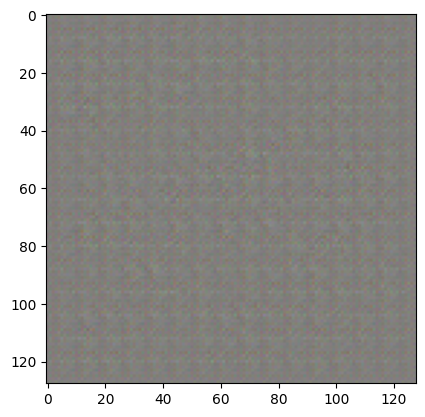

Training Epoch 14:   0%|          | 1/377 [01:30<9:29:32, 90.88s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise + embedded labels): torch.Size([50, 200])
Shape after self.fc: torch.Size([50, 4096])
Shape after reshaping out: torch.Size([50, 256, 4, 4])
Shape after downsampling out: torch.Size([50, 128, 4, 4])
Shape after residual block: torch.Size([50, 128, 4, 4])
Shape after Attention block: torch.Size([50, 128, 4, 4])
Shape after Noise injection: torch.Size([50, 128, 4, 4])
Shape before deconvolution: torch.Size([50, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([50, 3, 128, 128])
Min pixel

Training Epoch 14:   1%|          | 2/377 [02:23<7:06:59, 68.32s/it]

Epoch 13, G Loss: 3.782989740371704, D Loss: 0.0


Training Epoch 14:   1%|          | 2/377 [02:23<7:29:27, 71.91s/it]


Training: Epoch 14 - D Loss: 0.0075, G Loss: 0.0748
Epoch 15/60
Freezing Discriminator for this epoch...


Training Epoch 15:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise + embedded labels): torch.Size([50, 200])
Shape after self.fc: torch.Size([50, 4096])
Shape after reshaping out: torch.Size([50, 256, 4, 4])
Shape after downsampling out: torch.Size([50, 128, 4, 4])
Shape after residual block: torch.Size([50, 128, 4, 4])
Shape after Attention block: torch.Size([50, 128, 4, 4])
Shape after Noise injection: torch.Size([50, 128, 4, 4])
Shape before deconvolution: torch.Size([50, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([50, 3, 128, 128])
Min pixel

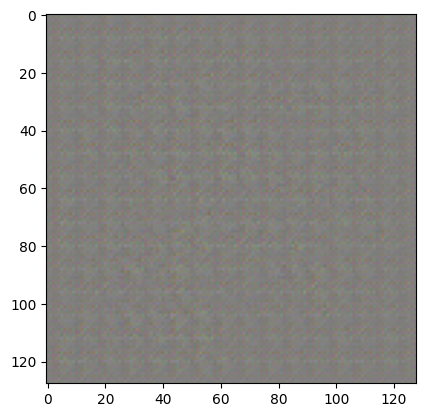

Training Epoch 15:   0%|          | 1/377 [00:44<4:39:19, 44.57s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (noise + embedded labels): torch.Size([51, 200])
Shape after self.fc: torch.Size([51, 4096])
Shape after reshaping out: torch.Size([51, 256, 4, 4])
Shape after downsampling out: torch.Size([51, 128, 4, 4])
Shape after residual block: torch.Size([51, 128, 4, 4])
Shape after Attention block: torch.Size([51, 128, 4, 4])
Shape after Noise injection: torch.Size([51, 128, 4, 4])
Shape before deconvolution: torch.Size([51, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([51, 3, 128, 128])
Min pixel

Training Epoch 15:   1%|          | 2/377 [01:28<4:34:45, 43.96s/it]

Epoch 14, G Loss: 3.6956872940063477, D Loss: 0.0


Training Epoch 15:   1%|          | 2/377 [01:28<4:36:40, 44.27s/it]


Training: Epoch 15 - D Loss: 0.0000, G Loss: 0.0749
Epoch 16/60


Training Epoch 16:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 4, 7, 0, 2, 6, 1, 0, 4, 0, 6, 2, 7, 5, 7, 4, 4, 8, 8, 2, 3, 3, 3, 6,
        1, 4, 8, 6, 5, 4, 6, 0, 3, 0, 7, 5, 5, 3, 7, 1, 3, 2, 8, 2, 1, 6, 2, 4,
        7, 5])
Shape of Real Images (with Noise): torch.Size([50, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([50, 3, 128, 128])
Shape of labels: torch.Size([50, 12, 128, 128])
Input Shape to initial_conv: torch.Size([50, 15, 128, 128])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise +

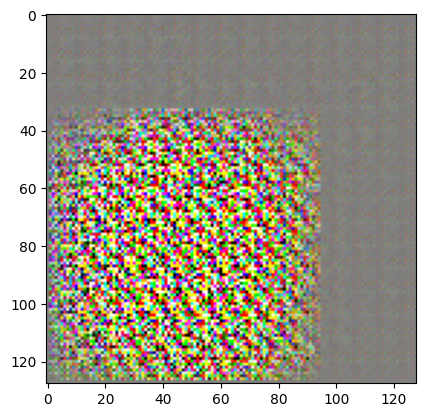

Training Epoch 16:   0%|          | 1/377 [01:29<9:19:53, 89.34s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise + embedded labels): torch.Size([50, 200])
Shape after self.fc: torch.Size([50, 4096])
Shape after reshaping out: torch.Size([50, 256, 4, 4])
Shape after downsampling out: torch.Size([50, 128, 4, 4])
Shape after residual block: torch.Size([50, 128, 4, 4])
Shape after Attention block: torch.Size([50, 128, 4, 4])
Shape after Noise injection: torch.Size([50, 128, 4, 4])
Shape before deconvolution: torch.Size([50, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([50, 3, 128, 128])
Min pixel

Training Epoch 16:   1%|          | 2/377 [02:20<6:59:12, 67.07s/it]

Epoch 15, G Loss: 3.288649082183838, D Loss: 0.0


Training Epoch 16:   1%|          | 2/377 [02:21<7:21:53, 70.70s/it]


Training: Epoch 16 - D Loss: 0.0074, G Loss: 0.0714
Epoch 17/60


Training Epoch 17:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 4, 7, 0, 2, 6, 1, 0, 4, 0, 6, 2, 7, 5, 7, 4, 4, 8, 8, 2, 3, 3, 3, 6,
        1, 4, 8, 6, 5, 4, 6, 0, 3, 0, 7, 5, 5, 3, 7, 1, 3, 2, 8, 2, 1, 6, 2, 4,
        7, 5])
Shape of Real Images (with Noise): torch.Size([50, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([50, 3, 128, 128])
Shape of labels: torch.Size([50, 12, 128, 128])
Input Shape to initial_conv: torch.Size([50, 15, 128, 128])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Validity Shape: torch.Size([50, 1])
Auxiliary Prediction Shape: torch.Size([50, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([50, 12])
Shape after embedded_labels: torch.Size([50, 100])
Shape of combined (noise +

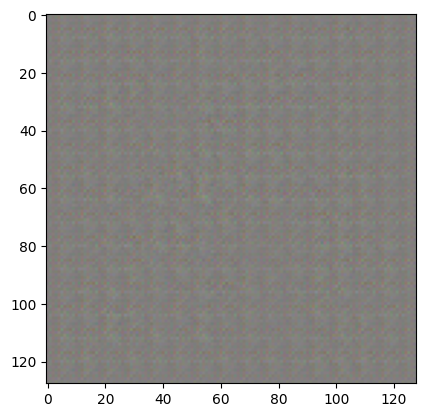

Training Epoch 17:   0%|          | 1/377 [01:29<9:20:53, 89.50s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (noise + embedded labels): torch.Size([51, 200])
Shape after self.fc: torch.Size([51, 4096])
Shape after reshaping out: torch.Size([51, 256, 4, 4])
Shape after downsampling out: torch.Size([51, 128, 4, 4])
Shape after residual block: torch.Size([51, 128, 4, 4])
Shape after Attention block: torch.Size([51, 128, 4, 4])
Shape after Noise injection: torch.Size([51, 128, 4, 4])
Shape before deconvolution: torch.Size([51, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([51, 3, 128, 128])
Min pixel

Training Epoch 17:   1%|          | 2/377 [02:24<7:30:22, 72.06s/it]


Training: Epoch 17 - D Loss: 0.0074, G Loss: 0.0731
Epoch 18/60


Training Epoch 18:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 4, 7, 0, 2, 7, 1, 0, 4, 0, 6, 2, 7, 6, 7, 3, 3, 9, 9, 1, 3, 3, 3, 6,
        1, 4, 9, 6, 4, 3, 6, 7, 0, 2, 0, 9, 4, 4, 2, 7, 1, 2, 2, 9, 2, 0, 6, 1,
        3, 7, 4])
Shape of Real Images (with Noise): torch.Size([51, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([51, 3, 128, 128])
Shape of labels: torch.Size([51, 12, 128, 128])
Input Shape to initial_conv: torch.Size([51, 15, 128, 128])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (nois

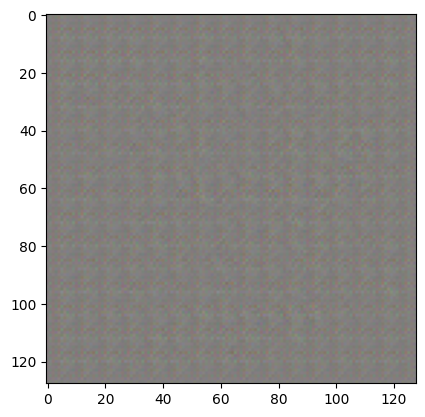

Training Epoch 18:   0%|          | 1/377 [01:35<10:00:18, 95.79s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([48, 12])
Shape after embedded_labels: torch.Size([48, 100])
Shape of combined (noise + embedded labels): torch.Size([48, 200])
Shape after self.fc: torch.Size([48, 4096])
Shape after reshaping out: torch.Size([48, 256, 4, 4])
Shape after downsampling out: torch.Size([48, 128, 4, 4])
Shape after residual block: torch.Size([48, 128, 4, 4])
Shape after Attention block: torch.Size([48, 128, 4, 4])
Shape after Noise injection: torch.Size([48, 128, 4, 4])
Shape before deconvolution: torch.Size([48, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([48, 3, 128, 128])
Min pixel

Training Epoch 18:   1%|          | 2/377 [02:23<7:01:56, 67.51s/it] 

Epoch 17, G Loss: 3.359916925430298, D Loss: 0.0


Training Epoch 18:   1%|          | 2/377 [02:23<7:29:48, 71.97s/it]


Training: Epoch 18 - D Loss: 0.0074, G Loss: 0.0723
Epoch 19/60


Training Epoch 19:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 5, 7, 0, 2, 7, 1, 0, 5, 0, 6, 2, 7, 6, 7, 3, 3, 8, 8, 1, 3, 3, 3, 6,
        1, 5, 8, 6, 5, 3, 6, 7, 0, 2, 0, 8, 5, 5, 2, 7, 1, 2, 2, 8, 2, 0, 6, 1,
        3, 7, 5])
Shape of Real Images (with Noise): torch.Size([51, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([51, 3, 128, 128])
Shape of labels: torch.Size([51, 12, 128, 128])
Input Shape to initial_conv: torch.Size([51, 15, 128, 128])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (nois

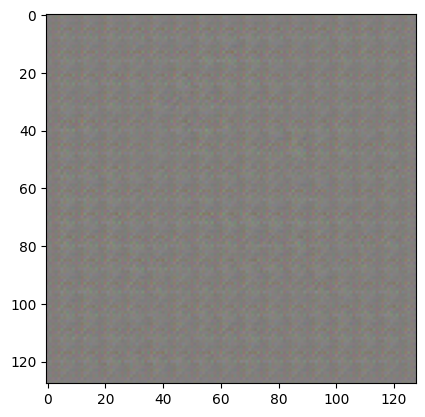

Training Epoch 19:   0%|          | 1/377 [01:32<9:37:52, 92.21s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (noise + embedded labels): torch.Size([51, 200])
Shape after self.fc: torch.Size([51, 4096])
Shape after reshaping out: torch.Size([51, 256, 4, 4])
Shape after downsampling out: torch.Size([51, 128, 4, 4])
Shape after residual block: torch.Size([51, 128, 4, 4])
Shape after Attention block: torch.Size([51, 128, 4, 4])
Shape after Noise injection: torch.Size([51, 128, 4, 4])
Shape before deconvolution: torch.Size([51, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([51, 3, 128, 128])
Min pixel

Training Epoch 19:   1%|          | 2/377 [02:26<7:38:35, 73.37s/it]


Training: Epoch 19 - D Loss: 0.0072, G Loss: 0.0649
Epoch 20/60
Freezing Discriminator for this epoch...


Training Epoch 20:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (noise + embedded labels): torch.Size([51, 200])
Shape after self.fc: torch.Size([51, 4096])
Shape after reshaping out: torch.Size([51, 256, 4, 4])
Shape after downsampling out: torch.Size([51, 128, 4, 4])
Shape after residual block: torch.Size([51, 128, 4, 4])
Shape after Attention block: torch.Size([51, 128, 4, 4])
Shape after Noise injection: torch.Size([51, 128, 4, 4])
Shape before deconvolution: torch.Size([51, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([51, 3, 128, 128])
Min pixel

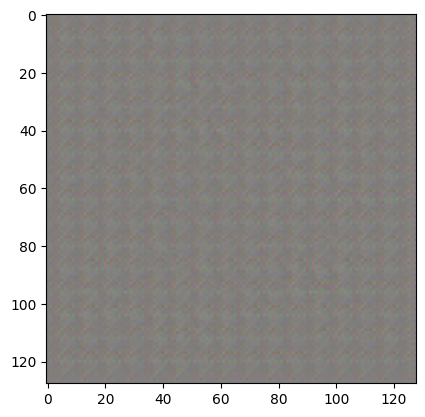

Training Epoch 20:   0%|          | 1/377 [00:48<5:02:16, 48.24s/it]

.......................................................
Training Discrimnator
.......................................................
.......................................................
Training Generator...............
.......................................................
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (noise + embedded labels): torch.Size([51, 200])
Shape after self.fc: torch.Size([51, 4096])
Shape after reshaping out: torch.Size([51, 256, 4, 4])
Shape after downsampling out: torch.Size([51, 128, 4, 4])
Shape after residual block: torch.Size([51, 128, 4, 4])
Shape after Attention block: torch.Size([51, 128, 4, 4])
Shape after Noise injection: torch.Size([51, 128, 4, 4])
Shape before deconvolution: torch.Size([51, 128, 4, 4])
Min pixel value: -1.0
Max pixel value: 1.0
Shape after Deconvolution layers: torch.Size([51, 3, 128, 128])
Min pixel

Training Epoch 20:   1%|          | 2/377 [01:32<4:45:43, 45.72s/it]

Epoch 19, G Loss: 3.4233760833740234, D Loss: 0.0


Training Epoch 20:   1%|          | 2/377 [01:32<4:49:21, 46.30s/it]


Training: Epoch 20 - D Loss: 0.0000, G Loss: 0.0700
Epoch 21/60


Training Epoch 21:   0%|          | 0/377 [00:00<?, ?it/s]

.......................................................
Training Discrimnator
.......................................................
all_labels------------------------>12
labels------------------------>tensor([1, 4, 6, 0, 2, 6, 1, 0, 4, 0, 5, 2, 6, 5, 6, 3, 3, 9, 9, 1, 3, 3, 3, 5,
        1, 4, 9, 5, 4, 3, 5, 6, 0, 2, 0, 9, 4, 4, 2, 6, 1, 2, 2, 9, 2, 0, 5, 1,
        3, 6, 4])
Shape of Real Images (with Noise): torch.Size([51, 3, 128, 128])
Inside Discriminator ..............................
Shape of images: torch.Size([51, 3, 128, 128])
Shape of labels: torch.Size([51, 12, 128, 128])
Input Shape to initial_conv: torch.Size([51, 15, 128, 128])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Validity Shape: torch.Size([51, 1])
Auxiliary Prediction Shape: torch.Size([51, 12])
Inside Generator .............................
Shape of labels before processing: torch.Size([51, 12])
Shape after embedded_labels: torch.Size([51, 100])
Shape of combined (nois

In [ ]:
train_dir = "/content/dataset/train"
val_dir = "/content/dataset/val"
d_losses, g_losses, val_d_losses, val_g_losses = train_gan(mean_real_data, std_real_data, train_loader, val_loader, epochs=60, device='cpu', accumulation_steps=4)

In [ ]:
model = nn.Sequential(
    nn.Conv2d(15, 64, kernel_size=4, stride=2, padding=1),
    nn.LeakyReLU(0.2, inplace=True),
)

x = torch.randn(51, 15, 128, 128)  # Simulate input
output = model(x)
print("Output Shape:", output.shape)  # Should be [51, 64, 64, 64]


Output Shape: torch.Size([51, 64, 64, 64])
